- 추가적인 테이블인 balance로부터 피쳐를 뽑아봄
- 하다보니 모든 테이블과 칼럼을 다 살펴볼 시간이 없음
- 몇 개만 뽑아봤는데, 성능의 개선이 보이긴 함

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "../take-home-interview/"

In [3]:
app = pd.read_csv(data_path + "loan_application.csv")
balance = pd.read_csv(data_path + "aave_loan_balance.csv")

In [4]:
loan_count = balance.groupby("application_id_current").size()

In [5]:
app_status_count = (
    balance.groupby(['application_id_current', 'name_contract_status']).size().reset_index(name='status_count')
    .pivot(index='application_id_current', columns='name_contract_status', values='status_count')
    .fillna(0).astype(int)
)

In [6]:
app_status_count.head()

name_contract_status,Active,Approved,Completed,Demand,Refused,Sent proposal,Signed
application_id_current,,,,,,,
100006,6,0,0,0,0,0,0
100011,74,0,0,0,0,0,0
100013,96,0,0,0,0,0,0
100021,7,0,10,0,0,0,0
100023,8,0,0,0,0,0,0


In [7]:
app_min_month = balance.groupby("application_id_current").months_balance.min()
app_max_balance = balance.groupby("application_id_current").amt_balance.max()

### Aggregate, balance only

In [8]:
import preprocess

In [9]:
balance_feature_df = app_status_count

In [10]:
balance_feature_df = balance_feature_df.assign(
    loan_count = loan_count,
    min_month = app_min_month,
    max_balance = app_max_balance
)

In [11]:
## ratio 추가
status_cols = balance.name_contract_status.unique()
ratio_df = pd.concat([
    balance_feature_df[status_col] / balance_feature_df['loan_count'] for status_col in status_cols
], axis=1)
ratio_cols = [f"{col}_ratio" for col in status_cols]
ratio_df.columns = ratio_cols

In [12]:
balance_feature_df = pd.concat([balance_feature_df, ratio_df], axis=1)

In [13]:
df = app.loc[app['type'] == 'train', ['application_id_current', 'target']].reset_index(drop=True)
df = df.merge(balance_feature_df, on="application_id_current", how='inner')

In [14]:
null_to_zero_columns = ['Active', 'Approved', 'Completed', 'Demand', 'Refused', 'Sent proposal', 'Signed', 'loan_count']
for col in null_to_zero_columns:
    df[col] = df[col].fillna(0).astype(int)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['application_id_current', 'target'], axis=1), df['target'], test_size=0.2
)

### evaluate

In [17]:
import evaluate_with_lightgbm

auc_dic = {}

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 4813, number of negative: 50806
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 55619, number of used features: 11
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086535 -> initscore=-2.356694
[LightGBM] [Info] Start training from score -2.356694
Tr

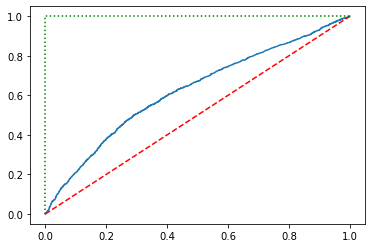

AUC on train: 0.6739
AUC on test: 0.6240
f1_score on train: 0.2347
f1_score on test: 0.2093


In [19]:
auc_dic['balance_only'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 4869, number of negative: 50750
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 55619, number of used features: 11
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087542 -> initscore=-2

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's auc: 0.619786
[80]	valid_0's auc: 0.618788
[100]	valid_0's auc: 0.616249
[120]	valid_0's auc: 0.61455
[140]	valid_0's auc: 0.614386
Early stopping, best iteration is:
[46]	valid_0's auc: 0.620064
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 4869, number of negative: 50750
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 55619, number of used features: 3
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [bina

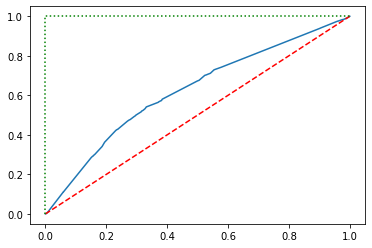

AUC on train: 0.6304
AUC on test: 0.6226
f1_score on train: 0.0000
f1_score on test: 0.0000


In [20]:
auc_dic['balance_only_feature_select'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test, X_train.shape[1] // 5)

### Aggregate, app X balance

In [35]:
df = app.loc[app['type'] == 'train'].drop('type', axis=1).reset_index(drop=True)
df = df.merge(balance_feature_df, on="application_id_current", how='left')

In [36]:
null_to_zero_columns = [
    *status_cols,
    *ratio_cols,
    'loan_count']
for col in null_to_zero_columns:
    df[col] = df[col].fillna(0).astype(int)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['application_id_current', 'target'], axis=1), df['target'], test_size=0.2
)

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 15828, number of negative: 180978
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11990
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 125
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080424 -> initsco

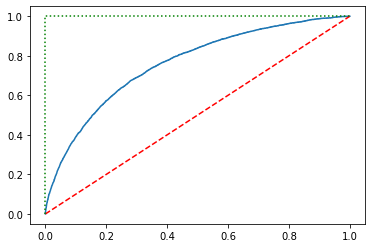

AUC on train: 0.8031
AUC on test: 0.7604
f1_score on train: 0.2982
f1_score on test: 0.2788


In [39]:
auc_dic['balanceXapp'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test)

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 15799, number of negative: 181007
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11994
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 124
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080277 -> initsco

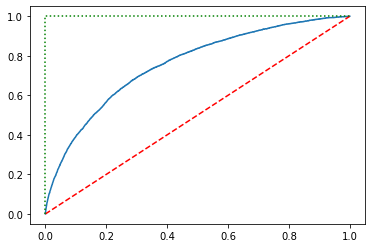

AUC on train: 0.7900
AUC on test: 0.7578
f1_score on train: 0.2874
f1_score on test: 0.2745


In [40]:
auc_dic['balanceXapp_feature_selected'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test, X_train.shape[1] // 5)

### App only

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 15762, number of negative: 181044
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11369
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 115
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080089 -> initscore=-2.441138
[LightGBM] [Info] Start training from score -2.441138
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.74331
[40

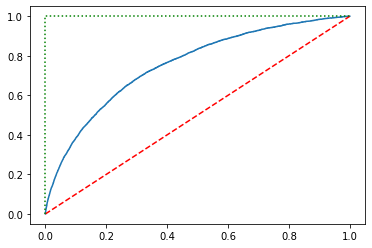

AUC on train: 0.8028
AUC on test: 0.7545
f1_score on train: 0.2965
f1_score on test: 0.2773


In [41]:
df = app.loc[app['type'] == 'train'].drop('type', axis=1).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['application_id_current', 'target'], axis=1), df['target'], test_size=0.2
)
auc_dic['app_only'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test)

### Final result

In [42]:
pd.Series(auc_dic).sort_values().reset_index()

,index,0
0,balance_only_feature_select,0.622618
1,balance_only,0.624024
2,app_only,0.754547
3,balanceXapp_feature_selected,0.757826
4,balanceXapp,0.760385
